In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from mido import MidiFile
import os

In [2]:
test_path = 'samples/music/jazz/'

files = os.listdir(test_path)
mpb = []
tpb = []
f_files = []
rolls = []
for f in sorted(files):
    try:
        t = 0
        note_found = False
        discard = False
        mpb_i = None
        mid_temp = MidiFile(os.path.join(test_path, f), clip=True)
        notes = {
            n: {'start': [], 'end': [], 'velocity': []}
            for n in range(128)
        }
        for track in mid_temp.tracks:
            for msg in track:
                if not msg.is_meta:
                    if msg.type == 'note_on':
                        if note_found:
                            t += msg.time
                        else:
                            t = 0
                            note_found = True
                        if msg.velocity > 0:
                            notes[msg.note]['start'].append(t // mid_temp.ticks_per_beat)
                            notes[msg.note]['velocity'].append(msg.velocity)
                        else:
                            notes[msg.note]['end'].append(t // mid_temp.ticks_per_beat)
                    if msg.type == 'note_off':
                        t += msg.time
                        notes[msg.note]['end'].append(t // mid_temp.ticks_per_beat)
                else:
                    if msg.type == 'set_tempo':
                        if mpb_i is None:
                            mpb_i = msg.tempo
                        else:
                            discard = True
                    elif msg.type == 'time_signature':
                        if msg.numerator != 4 and  msg.denominator != 4:
                            print(msg)

        if not discard:
            f_files.append(f) 
            tpb.append(mid_temp.ticks_per_beat)
            mpb.append(mpb_i)
            piano_roll = np.zeros((128, t // mid_temp.ticks_per_beat))
            for n, events in notes.items():
                if len(events['start']) > 0:
                    for n_ini, n_end, v in zip(events['start'], events['end'], events['velocity']):
                        piano_roll[n, n_ini:n_end] = v / 127
            rolls.append(piano_roll)
    except EOFError:
        pass
    
max_notes = [
    np.max(np.sum(roll, axis=0)).astype(int)
    for roll in rolls
]
print(
    '{:d} piano test rolls loaded with '
    '[{:02d}, {:02d}] - {:5.3f} ± {:5.3f}'.format(
        len(rolls), np.min(max_notes), np.max(max_notes),
        np.mean(max_notes), np.std(max_notes)
    )
)

304 piano test rolls loaded with [02, 08] - 3.780 ± 1.042


In [3]:
from datasets import MotifDataset
motif_size = 64
paths = [
    'samples/music/giantpiano/',
    'samples/music/classical/',
    'samples/music/maestro/',
]
dataset = MotifDataset(paths, motif_size=motif_size, notespbeat=20)

Unreadable Leifs, Jón, 4 Piano Pieces, Op.2, qgJ2dV6L3Ac.mid
Unreadable Liszt, Franz, Concerto pathétique, S.258, VkZPzfwL0xw.mid
6581 piano rolls loaded with [00, 19] - 11.097 ± 4.100


In [4]:
from models import MusicTransformer
from torch.utils.data import DataLoader


batch_size = 32

net = MusicTransformer([128, 128, 128])
n_param = sum(
    p.numel() for p in net.parameters() if p.requires_grad
)
print('Network ready {:d} parameters'.format(n_param))

train_loader = DataLoader(
    dataset, batch_size, True, num_workers=1
)
val_loader = DataLoader(
    dataset, batch_size, num_workers=1
)

net.fit(train_loader, val_loader, epochs=10, patience=10)
# net.load_model('weights/all.pt')

Network ready 397568 parameters
Epoch num |  train  |   val   |   xent   |   mse    |    l1    |   0mse   |   1mse   |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
----------|---------|---------|----------|----------|----------|----------|----------|
Init      |  5.7113 |  1.2138 |   1.2138 |   0.3507 |   0.4956 |   0.0277 |   0.9723 | 30s
Epoch 000 |  1.8423 |  0.5106 |   0.5106 |   0.1673 |   0.3161 |   0.0277 |   0.9723 | 1m 25s                                                                                                 

In [5]:
net.save_model('weights/all.pt')

[1.         1.         1.         0.         0.         1.
 1.         1.         0.         0.         0.         1.
 1.         1.         0.         0.         1.         1.
 1.         1.         1.         1.         1.         0.
 0.         1.         1.         0.         1.         1.
 1.         1.         0.54536706 0.5267001  0.63154465 0.53988886
 0.54446656 0.5471496  0.540247   0.5294419  0.60297924 0.6207751
 0.5370371  0.5519673  0.53022116 0.57095903 0.5667326  0.5351697
 0.59802663 0.5076782  0.69960254 0.5848734  0.60814816 0.64816856
 0.5343089  0.5651935  0.6640233  0.6166179  0.66922206 0.59075946
 0.5757821  0.5510532  0.53325266 0.64164525]


<IPython.core.display.Javascript object>


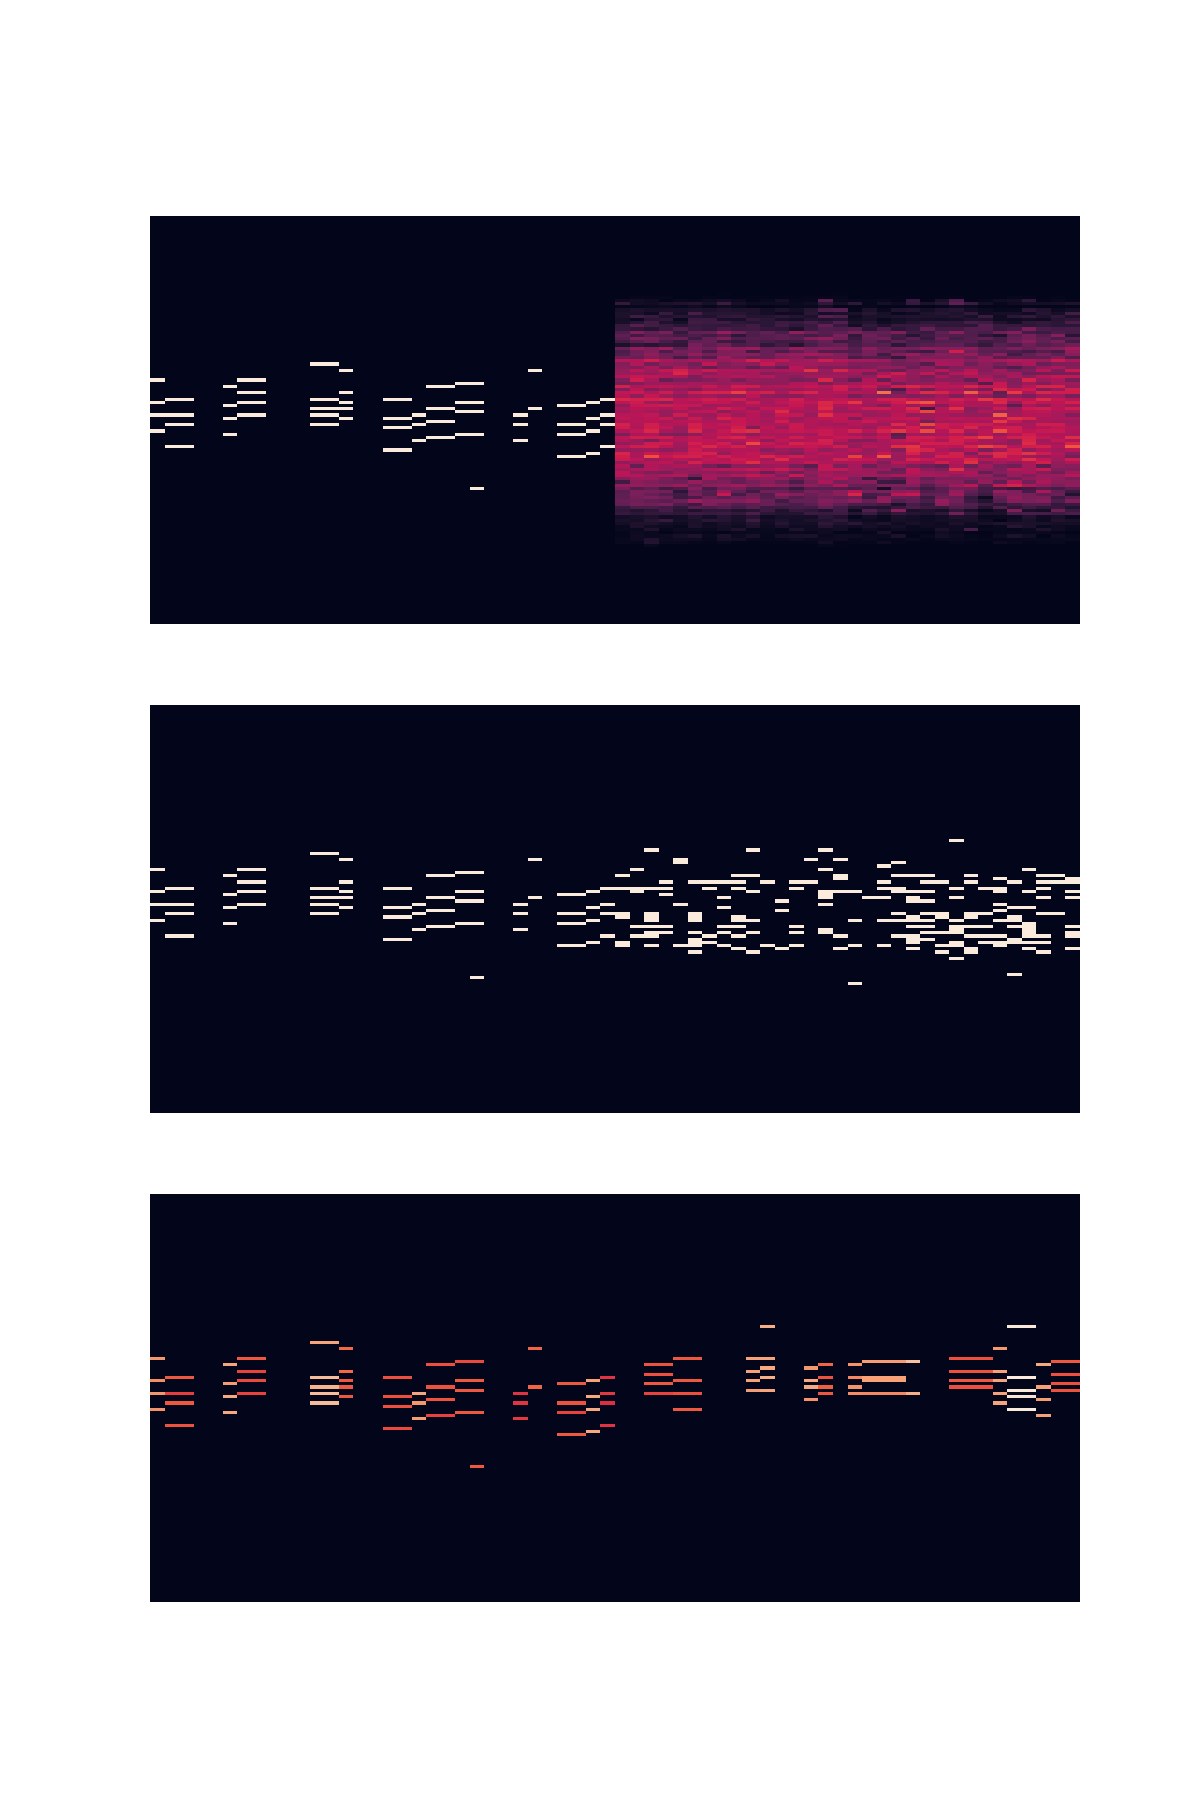

[]

In [15]:
rand_idx = np.random.randint(0, len(rolls))
random_roll = rolls[rand_idx]
random_tpb = tpb[rand_idx]
random_motif = random_roll[:, :motif_size].astype(np.float32)
random_vel = np.mean(random_motif[random_motif > 0])
song = random_roll[:, :motif_size + motif_size] 
pred_song = net.song((random_motif > 0).astype(np.float32), motif_size)
print(np.max(pred_song, axis=0))
plt.figure(figsize=(12, 18))
# plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
# sn.heatmap(song, cbar=False)
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.subplot(2, 1, 2)
final_song = np.concatenate([
    random_motif,
    pred_song[:, motif_size:]
], axis=1)
# sn.heatmap(final_song, cbar=False)
sn.heatmap(pred_song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(3, 1, 2)
sn.heatmap(pred_song > 0.5, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(3, 1, 3)
sn.heatmap(song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[0.         0.97637795 0.8503937  0.77165354 0.74015748 0.77165354
 0.81102362 0.         0.70866142 0.77165354 0.81102362 0.81102362
 0.         0.         0.         0.77165354 0.74015748 0.8503937
 0.77165354 0.81102362 0.68503937 0.77165354 0.         0.
 0.74015748 0.74015748 0.8503937  0.77165354 0.70866142 0.8503937
 0.         0.8503937  0.8503937  0.8503937  0.8503937  0.81102362
 0.         0.81102362 0.8503937  0.77165354 0.70866142 0.
 0.77165354 0.         0.77165354 0.77165354 0.74015748 0.74015748
 0.70866142 0.74015748 0.70866142 0.8503937  0.70866142 0.
 0.         0.81102362 0.74015748 0.81102362 0.         0.77165354
 0.70866142 0.8503937  0.74015748 0.8503937  0.         0.90551181
 0.8503937  0.81102362 0.77165354 0.81102362 0.77165354 0.81102362
 0.77165354 0.         0.8503937  0.77165354 0.         0.
 0.8503937  0.68503937 0.8503937  0.         0.77165354 0.
 0.74015748 0.70866142 0.74015748 0.81102362 0.         0.
 0.         0.         0.         0.         

<IPython.core.display.Javascript object>


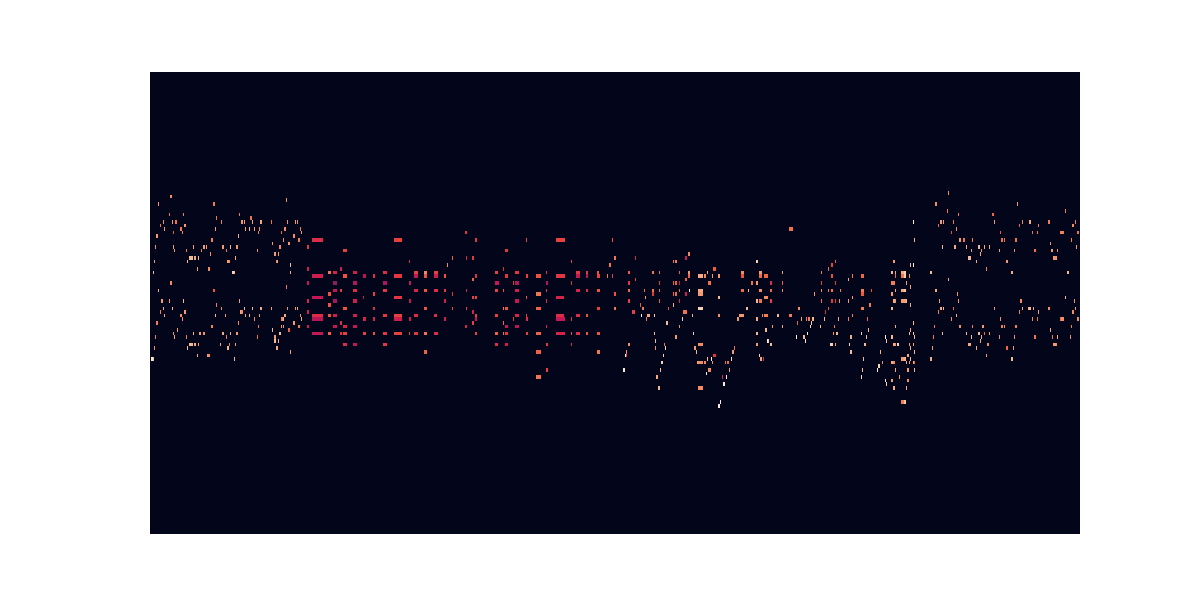

[]

In [7]:
rand_idx = np.random.randint(0, len(rolls))
random_roll = rolls[rand_idx]
random_tpb = tpb[rand_idx]
random_motif = random_roll[:, :motif_size].astype(np.float32)
random_vel = np.mean(random_motif[random_motif > 0])
song = random_roll[:, :motif_size + 32] 
# pred_song = net.song((random_motif > 0).astype(np.float32), 32)
# print(np.max(pred_song, axis=0))
print(np.max(random_roll, axis=0))
# plt.figure(figsize=(12, 12))
plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# sn.heatmap(song, cbar=False)
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.subplot(2, 1, 2)
# final_song = np.concatenate([
#     random_motif,
#     random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
# ], axis=1)
# sn.heatmap(final_song, cbar=False)
sn.heatmap(random_roll, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

In [8]:
from mido import Message, MetaMessage, MidiFile, MidiTrack

def roll_to_midi(path, name, roll, timing):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    notes = []
    next_t = 0
    for beat in np.moveaxis(roll, 0, 1):
        beat_notes = np.where(np.squeeze(beat) > 0)[0]
        if len(beat_notes) > 0:
            for note in beat_notes:
                if not (note in notes):
                    track.append(Message(
                        'note_on', time=next_t * timing, note=note, 
                        velocity=int(np.squeeze(beat)[note] * 127)))
                    print('Note on', note, int(np.squeeze(beat)[note] * 127), next_t * timing
                         )
                    notes.append(note)
                    next_t = 0
            for note in notes:
                if not (note in beat_notes):
                    track.append(Message('note_on', time=next_t * timing, note=note, velocity=0))
                    print('Note off', note)
                    next_t = 0
            notes = beat_notes.tolist()
        else:
            for note in notes:
                track.append(Message('note_on', time=next_t * timing, note=note, velocity=0))
                print('Note off', note, next_t * timing)
            notes = []
        next_t += 1
    mid.save(os.path.join(path, name))

    
for i in range(10):
    rand_idx = np.random.randint(0, len(rolls))
    random_roll = rolls[rand_idx]
    random_tpb = tpb[rand_idx]
    random_motif = random_roll[:, :motif_size].astype(np.float32)
    random_vel = np.mean(random_motif[random_motif > 0])
    song = random_roll[:, :motif_size + 32] 
    pred_song = net.song((random_motif > 0).astype(np.float32), 128)
#     final_song = np.concatenate([
#         random_motif,
#         random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
#     ], axis=1)
    final_song = random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
    roll_to_midi('samples/music/', 'test{:02d}.mid'.format(i), final_song, random_tpb)
    roll_to_midi('samples/music/', 'test_init{:02d}.mid'.format(i), random_roll, random_tpb)

Note on 54 57 960
Note on 60 53 0
Note on 65 62 0
Note off 54 192
Note off 60 192
Note off 65 192
Note on 72 78 384
Note off 72 192
Note on 69 97 384
Note on 52 50 384
Note on 57 70 0
Note on 61 75 0
Note on 64 74 0
Note on 51 83 192
Note on 55 64 0
Note on 67 99 0
Note off 52
Note off 57
Note off 61
Note off 64
Note off 69
Note off 51 192
Note off 55 192
Note off 67 192
Note on 45 61 384
Note on 52 64 0
Note on 59 63 0
Note on 60 57 0
Note on 67 58 0
Note off 45 192
Note off 52 192
Note off 59 192
Note off 60 192
Note off 67 192
Note on 62 97 2304
Note on 69 72 192
Note off 62
Note on 57 73 192
Note off 69
Note off 57 192
Note on 51 71 576
Note on 55 63 0
Note on 61 79 0
Note off 51 192
Note off 55 192
Note off 61 192
Note on 45 61 576
Note on 55 73 0
Note on 60 76 0
Note on 56 79 192
Note on 62 79 0
Note off 45
Note off 55
Note off 60
Note on 49 57 192
Note on 55 64 0
Note on 58 82 0
Note on 64 78 0
Note off 56
Note off 62
Note on 50 55 192
Note on 57 70 0
Note off 49
Note off 55
Not

Note on 36 49 0
Note on 71 36 0
Note on 76 22 0
Note on 79 40 0
Note on 83 51 0
Note off 36 120
Note off 71 120
Note off 76 120
Note off 79 120
Note off 83 120
Note on 54 38 240
Note on 58 53 0
Note on 63 43 0
Note off 54 120
Note off 58 120
Note off 63 120
Note on 48 35 240
Note on 55 30 0
Note on 59 38 0
Note on 67 66 0
Note on 71 65 0
Note off 48
Note off 59
Note off 67
Note off 71
Note off 55 120
Note on 53 65 240
Note on 58 58 0
Note on 63 65 0
Note on 51 38 120
Note on 74 27 0
Note off 53
Note off 58
Note off 63
Note off 74
Note on 42 34 120
Note on 57 34 0
Note on 61 43 0
Note off 51
Note off 42 120
Note off 57 120
Note off 61 120
Note on 54 43 240
Note on 57 33 120
Note off 54
Note on 51 46 120
Note on 64 37 0
Note off 57
Note on 43 41 120
Note on 54 64 0
Note on 59 59 0
Note on 62 81 0
Note on 66 67 0
Note on 69 82 0
Note off 51
Note off 64
Note off 54
Note on 61 43 120
Note on 65 62 0
Note on 73 67 0
Note off 43
Note off 59
Note off 62
Note off 66
Note off 69
Note on 58 31 12

Note on 79 74 0
Note on 57 48 768
Note on 61 37 0
Note on 63 44 0
Note on 68 35 0
Note on 83 48 0
Note on 95 64 0
Note off 79
Note off 95
Note off 57 384
Note off 61 384
Note off 63 384
Note off 68 384
Note off 83 384
Note on 61 67 1152
Note on 53 33 384
Note on 57 40 0
Note on 60 40 0
Note on 64 34 0
Note off 61
Note off 60
Note off 64
Note on 89 74 768
Note off 53
Note off 57
Note on 87 36 384
Note off 89
Note on 51 38 384
Note on 84 51 0
Note off 87
Note off 51
Note on 52 40 384
Note on 57 26 0
Note on 62 35 0
Note on 72 53 0
Note off 84
Note on 79 57 384
Note off 52
Note off 57
Note off 62
Note off 72
Note on 57 44 384
Note on 61 36 0
Note on 63 45 0
Note on 68 56 0
Note off 79
Note on 56 51 384
Note on 62 52 0
Note on 67 64 0
Note on 76 78 0
Note off 57
Note off 61
Note off 63
Note off 68
Note on 55 45 384
Note on 61 40 0
Note on 65 31 0
Note off 56
Note off 62
Note off 67
Note off 76
Note on 74 76 384
Note off 55
Note off 61
Note off 65
Note on 60 24 384
Note off 74
Note on 74 41

Note on 94 77 0
Note off 92
Note on 90 83 384
Note off 94
Note on 92 80 384
Note off 61
Note off 65
Note off 90
Note on 86 33 384
Note off 55
Note off 56
Note off 92
Note on 52 35 384
Note on 57 34 0
Note on 62 43 0
Note off 86
Note on 77 61 384
Note off 52 384
Note off 57 384
Note off 62 384
Note off 77 384
Note on 67 50 768
Note on 56 35 384
Note on 60 43 0
Note on 62 51 0
Note on 55 37 384
Note off 56
Note off 60
Note off 62
Note off 67
Note on 61 32 384
Note on 65 24 0
Note on 88 73 0
Note on 54 30 384
Note on 60 31 0
Note on 64 31 0
Note on 84 49 0
Note off 55
Note off 61
Note off 65
Note off 88
Note off 64
Note off 84
Note on 64 33 384
Note on 80 58 0
Note on 76 40 384
Note off 80
Note on 68 56 384
Note off 60
Note off 64
Note off 76
Note off 54 384
Note off 68 384
Note on 60 68 1536
Note on 52 47 384
Note on 57 70 0
Note on 67 79 0
Note on 64 54 384
Note on 65 74 0
Note on 69 78 0
Note on 72 67 0
Note on 76 85 0
Note off 52
Note off 57
Note off 60
Note off 67
Note on 56 55 384
N

Note on 65 45 480
Note on 66 73 0
Note off 51
Note off 55
Note off 57
Note off 62
Note off 72
Note on 63 45 480
Note off 66
Note on 60 66 480
Note off 63
Note off 65
Note on 65 52 480
Note on 66 91 0
Note off 60
Note on 58 84 480
Note on 63 79 0
Note off 65
Note off 66
Note on 54 82 480
Note on 60 67 0
Note off 58
Note off 63
Note on 48 67 480
Note off 54
Note off 60
Note on 53 55 480
Note off 48
Note on 58 32 480
Note on 63 27 0
Note on 71 64 0
Note off 53
Note on 51 47 480
Note on 57 60 0
Note on 62 52 0
Note on 65 55 0
Note off 58
Note off 63
Note off 71
Note off 51 480
Note off 57 480
Note off 62 480
Note off 65 480
Note on 50 55 960
Note on 56 66 0
Note on 60 66 0
Note on 67 64 0
Note on 68 68 0
Note on 71 57 0
Note on 65 34 480
Note off 67
Note off 68
Note off 71
Note on 67 64 480
Note on 68 58 0
Note on 71 67 0
Note off 50
Note off 56
Note off 60
Note off 65 480
Note off 67 480
Note off 68 480
Note off 71 480
Note on 84 55 960
Note on 53 64 480
Note on 54 51 0
Note on 58 63 0
No

Note on 50 6 240
Note on 58 37 0
Note on 62 44 0
Note on 44 23 120
Note on 53 52 0
Note on 60 41 0
Note on 67 48 0
Note off 50
Note off 58
Note off 62
Note on 45 42 120
Note off 44
Note off 53
Note off 60
Note off 67
Note on 55 32 120
Note on 61 32 0
Note on 66 27 0
Note on 71 44 0
Note on 75 47 0
Note off 45
Note off 55 120
Note off 61 120
Note off 66 120
Note off 71 120
Note off 75 120
Note on 58 32 240
Note on 72 34 0
Note on 75 42 0
Note off 58 120
Note off 72 120
Note off 75 120
Note on 55 71 360
Note on 61 62 0
Note on 66 64 0
Note on 70 88 0
Note on 54 63 120
Note off 55
Note off 61
Note off 66
Note off 70
Note on 52 36 120
Note on 58 37 0
Note on 63 33 0
Note on 67 45 0
Note on 79 57 0
Note off 54
Note on 51 25 120
Note on 75 52 0
Note off 52
Note off 58
Note off 63
Note off 67
Note on 56 21 120
Note on 61 31 0
Note on 77 50 0
Note off 51
Note off 75
Note off 79
Note on 67 34 120
Note off 56
Note off 61
Note off 77
Note off 67 120
Note on 68 23 240
Note on 74 33 0
Note on 79 30

Note on 51 36 0
Note off 51 1920
Note on 63 46 3840
Note on 79 64 960
Note off 63
Note on 55 55 960
Note on 56 62 0
Note off 79
Note on 63 83 960
Note off 55
Note off 56
Note on 46 29 960
Note on 53 30 0
Note off 63
Note on 56 26 960
Note off 53
Note on 51 32 1920
Note on 59 20 0
Note on 62 34 0
Note on 66 48 0
Note on 69 46 0
Note on 74 64 0
Note off 46
Note off 56
Note on 60 37 960
Note on 75 64 0
Note off 59
Note off 62
Note off 66
Note off 69
Note off 74
Note off 51 960
Note off 60 960
Note off 75 960
Note on 58 37 1920
Note on 75 42 0
Note on 80 49 0
Note on 84 48 0
Note on 87 47 0
Note on 41 58 960
Note off 58
Note off 75
Note off 80
Note off 84
Note off 87
Note on 55 36 960
Note off 41
Note on 60 36 960
Note on 63 67 0
Note on 67 77 0
Note on 74 78 0
Note off 55
Note on 62 55 960
Note off 60
Note off 74
Note on 72 71 960
Note off 62
Note off 63
Note off 67
Note on 54 35 960
Note on 57 34 0
Note on 74 70 0
Note off 72
Note on 72 52 960
Note on 77 45 0
Note on 82 52 0
Note on 87 6

Note off 63
Note off 75
Note on 73 35 960
Note off 54
Note off 60
Note on 55 30 960
Note on 58 35 0
Note on 72 62 0
Note off 73
Note off 55 960
Note off 58 960
Note off 72 960
Note on 63 54 1920
Note on 43 39 960
Note on 53 44 0
Note on 58 46 0
Note off 63
Note on 49 63 960
Note on 59 71 0
Note on 63 69 0
Note on 67 67 0
Note on 70 57 0
Note off 43
Note off 53
Note off 58
Note on 68 64 960
Note off 49
Note off 59
Note off 63
Note off 67
Note off 70
Note on 36 63 960
Note on 64 66 0
Note on 67 67 0
Note off 68
Note off 36 960
Note off 64 960
Note off 67 960
Note on 58 71 1920
Note on 63 47 960
Note off 58
Note on 79 38 1920
Note on 83 64 960
Note off 63
Note off 79
Note on 56 53 960
Note on 62 57 0
Note on 67 57 0
Note on 79 57 0
Note off 83
Note on 82 72 960
Note off 67
Note off 79
Note on 51 48 960
Note on 72 71 0
Note on 80 59 0
Note on 84 74 0
Note off 56
Note off 82
Note off 51 960
Note off 62 960
Note off 72 960
Note off 80 960
Note off 84 960
Note on 63 83 3840
Note on 67 84 0
No

Note on 72 84 0
Note on 76 81 0
Note on 79 83 0
Note on 46 55 960
Note off 56
Note off 62
Note off 67
Note off 76
Note off 79
Note on 45 52 960
Note on 52 32 0
Note off 46
Note on 60 37 960
Note on 64 37 0
Note off 45
Note off 52
Note off 60 960
Note off 64 960
Note off 72 960
Note on 44 32 1920
Note on 54 36 0
Note on 59 36 0
Note on 63 48 0
Note on 69 48 0
Note off 44 960
Note off 54 960
Note off 59 960
Note off 63 960
Note off 69 960
Note on 65 30 1920
Note on 77 39 0
Note on 89 56 0
Note off 65 960
Note off 77 960
Note off 89 960
Note on 48 22 1920
Note on 65 34 0
Note on 70 36 0
Note on 74 37 0
Note on 58 25 960
Note on 77 34 0
Note off 58
Note off 74
Note on 57 42 960
Note on 69 37 0
Note on 72 44 0
Note off 65
Note off 70
Note off 57
Note off 69
Note off 72
Note on 60 47 960
Note on 66 68 0
Note on 70 62 0
Note on 72 54 0
Note on 75 32 0
Note off 60
Note off 66
Note off 75
Note on 60 35 960
Note on 68 36 0
Note on 73 38 0
Note off 70
Note off 72
Note off 60
Note off 68
Note off 

Note on 50 29 0
Note on 57 28 0
Note on 74 63 0
Note on 62 25 960
Note on 66 31 0
Note off 74
Note on 70 64 960
Note on 74 65 0
Note off 57
Note off 62
Note on 58 37 960
Note off 74
Note off 50
Note off 66
Note off 70
Note on 50 24 960
Note on 59 80 0
Note on 71 77 0
Note on 78 64 0
Note off 58
Note on 67 88 960
Note off 50
Note off 59
Note on 50 51 960
Note on 61 67 0
Note off 71
Note off 78
Note on 76 39 960
Note on 59 71 960
Note on 66 40 0
Note on 69 46 0
Note on 74 56 0
Note off 50
Note off 61
Note off 67
Note off 76
Note on 57 90 960
Note off 59
Note off 69
Note off 74
Note on 50 60 960
Note off 66
Note off 50 960
Note off 57 960
Note on 71 54 2880
Note on 72 59 0
Note on 76 57 0
Note on 79 49 0
Note on 83 53 0
Note off 71 960
Note off 72 960
Note off 76 960
Note off 79 960
Note off 83 960
Note on 75 49 1920
Note on 60 31 960
Note on 66 25 0
Note on 70 35 0
Note on 74 43 0
Note off 75
Note on 72 43 960
Note off 60
Note off 66
Note off 74
Note on 50 29 960
Note on 59 17 0
Note off

Note on 39 32 0
Note on 46 30 0
Note on 62 39 0
Note on 67 40 0
Note off 62
Note off 67
Note on 68 93 120
Note off 39
Note off 46
Note off 68 120
Note on 51 39 240
Note on 65 57 0
Note off 51
Note on 39 27 120
Note on 46 27 0
Note on 55 45 0
Note off 65
Note off 39 120
Note off 46 120
Note off 55 120
Note on 55 47 240
Note on 60 31 0
Note on 62 28 0
Note on 65 38 0
Note on 74 74 0
Note off 55 120
Note off 60 120
Note off 62 120
Note off 65 120
Note off 74 120
Note on 43 32 360
Note on 59 36 0
Note on 63 31 0
Note on 67 33 0
Note off 43
Note on 48 16 120
Note on 55 30 0
Note on 58 25 0
Note on 60 24 0
Note off 59
Note off 67
Note on 51 64 120
Note off 55
Note off 58
Note off 60
Note off 63
Note on 53 48 120
Note on 67 60 0
Note off 48
Note off 51
Note on 77 74 120
Note on 86 77 0
Note off 53
Note off 67
Note off 77 120
Note off 86 120
Note on 54 28 240
Note on 58 32 0
Note on 70 57 0
Note on 48 41 120
Note on 75 57 0
Note off 54
Note off 70
Note off 75
Note off 58
Note on 45 30 120
Note

Note off 79
Note off 81
Note off 86
Note on 54 31 120
Note on 76 36 0
Note on 80 38 0
Note on 83 53 0
Note off 55
Note off 57
Note off 84
Note off 54 120
Note off 60 120
Note off 64 120
Note off 76 120
Note off 80 120
Note off 83 120
Note on 54 32 240
Note on 60 36 0
Note on 64 34 0
Note on 76 29 0
Note on 81 42 0
Note on 84 36 0
Note off 54
Note off 60
Note off 64
Note off 76
Note off 81
Note on 54 29 120
Note on 57 34 0
Note on 59 22 0
Note on 62 30 0
Note on 83 105 0
Note off 84
Note off 57
Note off 83
Note on 55 25 120
Note on 57 37 0
Note on 60 33 0
Note on 65 33 0
Note on 81 53 0
Note off 54
Note off 59
Note off 62
Note off 81
Note off 55 240
Note off 57 240
Note off 60 240
Note off 65 240
Note on 55 27 360
Note on 61 33 0
Note on 64 31 0
Note on 81 61 0
Note off 81
Note on 79 42 120
Note on 83 67 120
Note off 55
Note off 61
Note off 64
Note off 79
Note on 77 63 120
Note off 83
Note on 58 43 120
Note on 62 66 0
Note on 53 42 240
Note on 60 50 0
Note on 63 55 0
Note off 62
Note of